
# ResNet-style Network on a 2D Spiral Dataset

This notebook accompanies Section~\ref{sec:ResNet} of the *Mathematics of Generative AI*
living book.

We illustrate the effect of **residual (skip) connections** on a simple 2D classification
task: separating classes arranged in a spiral pattern. The goals are:

- construct a small fully-connected "ResNet-9"-style architecture with residual blocks,
- train it on the spiral dataset,
- visualize
  - the data,
  - the training curves (loss and accuracy),
  - the learned decision boundary,
  - an example of **gradient norms across layers**.

Figures are saved under `figs/` and referenced in the LaTeX text as:

- `figs/resnet9_spiral_data.png`
- `figs/resnet9_spiral_train_curves.png`
- `figs/resnet9_spiral_decision.png`
- `figs/resnet9_spiral_gradnorms.png`

In the exercise in the book, you are invited to **remove the skip connections** and
compare training dynamics and gradient flow to the residual case.


In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

os.makedirs("figs", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(0)
np.random.seed(0)


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Using device: cpu



## 1. Spiral Dataset

We generate a synthetic 2D dataset in which each class forms a spiral arm.
This is a standard toy problem that is not linearly separable but can be handled by
moderately expressive nonlinear classifiers.

We use three classes arranged in a spiral. Each data point is a vector
$x \in \mathbb{R}^2$, and the label is an integer $y \in \{0,1,2\}$.


In [2]:

def make_spiral(n_points_per_class=200, n_classes=3, noise=0.2):
    """Generate a 2D spiral dataset with n_classes arms."""
    N = n_points_per_class * n_classes
    X = np.zeros((N, 2), dtype=np.float32)
    y = np.zeros(N, dtype=np.int64)
    for j in range(n_classes):
        ix_start = j * n_points_per_class
        ix_end = (j + 1) * n_points_per_class
        r = np.linspace(0.0, 1, n_points_per_class)        # radius
        t = np.linspace(j * 4, (j + 1) * 4, n_points_per_class)
        t += np.random.randn(n_points_per_class) * noise   # angular noise
        X[ix_start:ix_end] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix_start:ix_end] = j
    return X, y

X, y = make_spiral(n_points_per_class=200, n_classes=3, noise=0.2)
print("X shape:", X.shape, "y shape:", y.shape)

X_t = torch.from_numpy(X)
y_t = torch.from_numpy(y)

dataset = TensorDataset(X_t, y_t)
batch_size = 128
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


X shape: (600, 2) y shape: (600,)



### Visualization of the Spiral Data

We plot the 2D inputs colored by class. This figure is referenced in the text to
illustrate the nontrivial geometry that the network must learn.


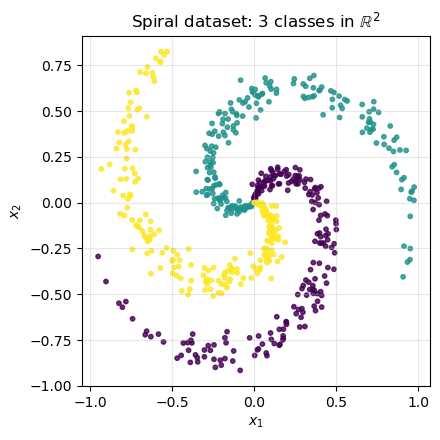

In [3]:

plt.figure(figsize=(4.5, 4.5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", s=10, alpha=0.8)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Spiral dataset: 3 classes in $\\mathbb{R}^2$")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/resnet9_spiral_data.png", dpi=300, bbox_inches="tight")
plt.show()



## 2. A Small ResNet-style Architecture in Feature Space

We now build a fully connected network inspired by ResNet:

- an initial linear layer that lifts $x \in \mathbb{R}^2$ into a higher-dimensional
  hidden space,
- several **residual blocks** of the form
  $$ h \mapsto \sigma\bigl( h + g(h) \bigr), $$
  where $g$ is a small two-layer MLP,
- a final linear layer that maps to 3 logits (one per class).

This mirrors the residual-block idea in convolutional ResNets, but in a simpler
fully connected setting better suited for 2D toy data.


In [4]:

class ResidualBlock(nn.Module):
    def __init__(self, dim, use_bn=True, use_skip=True):
        super().__init__()
        self.use_bn = use_bn
        self.use_skip = use_skip

        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)
        if use_bn:
            self.bn1 = nn.BatchNorm1d(dim)
            self.bn2 = nn.BatchNorm1d(dim)
        self.activation = nn.ReLU(inplace=True)

        # end __init__

    def forward(self, x):
        out = self.fc1(x)
        if self.use_bn:
            out = self.bn1(out)
        out = self.activation(out)
        out = self.fc2(out)
        if self.use_bn:
            out = self.bn2(out)

        if self.use_skip:
            out = out + x  # skip connection

        out = self.activation(out)
        return out


class ResNet9Spiral(nn.Module):
    """Small ResNet-style model for 2D inputs."""
    def __init__(self, input_dim=2, hidden_dim=64, num_classes=3,
                 use_bn=True, use_skip=True):
        super().__init__()
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.act_in = nn.ReLU(inplace=True)

        self.blocks = nn.ModuleList([
            ResidualBlock(hidden_dim, use_bn=use_bn, use_skip=use_skip)
            for _ in range(4)
        ])

        self.fc_out = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        h = self.act_in(self.fc_in(x))
        for block in self.blocks:
            h = block(h)
        logits = self.fc_out(h)
        return logits


model = ResNet9Spiral(input_dim=2, hidden_dim=64, num_classes=3,
                      use_bn=True, use_skip=True).to(device)
print(model)


ResNet9Spiral(
  (fc_in): Linear(in_features=2, out_features=64, bias=True)
  (act_in): ReLU(inplace=True)
  (blocks): ModuleList(
    (0-3): 4 x ResidualBlock(
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (fc2): Linear(in_features=64, out_features=64, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
  )
  (fc_out): Linear(in_features=64, out_features=3, bias=True)
)



## 3. Training with Cross-Entropy Loss and Adam

We train the network using cross-entropy loss and the Adam optimizer.
We track both loss and accuracy over epochs.


In [5]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(logits, dim=1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy



### Training Loop

We train for a modest number of epochs (e.g., 100–200). This is enough for the residual
network to learn a good approximation to the spiral decision boundaries.


In [6]:

n_epochs = 150

train_losses = []
train_accuracies = []

for epoch in range(1, n_epochs + 1):
    loss, acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(loss)
    train_accuracies.append(acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}/{n_epochs}: loss={loss:.4f}, acc={acc*100:.2f}%")


Epoch   1/150: loss=0.6254, acc=77.67%
Epoch  10/150: loss=0.0437, acc=98.50%
Epoch  20/150: loss=0.0463, acc=98.50%
Epoch  30/150: loss=0.0325, acc=98.83%
Epoch  40/150: loss=0.0348, acc=98.50%
Epoch  50/150: loss=0.0135, acc=99.83%
Epoch  60/150: loss=0.0379, acc=98.50%
Epoch  70/150: loss=0.0289, acc=99.17%
Epoch  80/150: loss=0.0365, acc=98.67%
Epoch  90/150: loss=0.0461, acc=98.17%
Epoch 100/150: loss=0.0198, acc=99.33%
Epoch 110/150: loss=0.0149, acc=99.33%
Epoch 120/150: loss=0.0222, acc=99.33%
Epoch 130/150: loss=0.0323, acc=98.33%
Epoch 140/150: loss=0.0118, acc=99.50%
Epoch 150/150: loss=0.0140, acc=99.33%



## 4. Training Curves

We now plot the training loss and accuracy as functions of the epoch index.
These curves are used in the text to illustrate the effect of residual learning
on optimization dynamics.


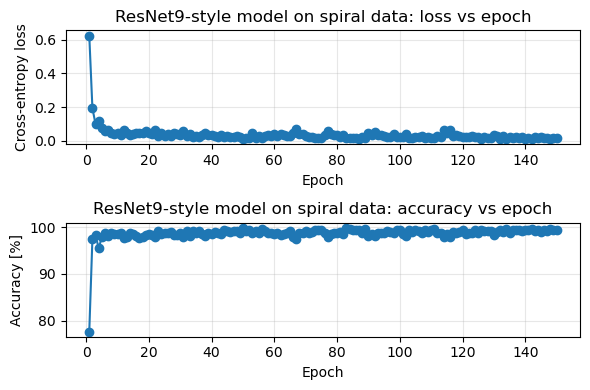

In [7]:

epochs = np.arange(1, n_epochs + 1)

plt.figure(figsize=(6, 4))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("ResNet9-style model on spiral data: loss vs epoch")
plt.grid(alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(epochs, np.array(train_accuracies) * 100, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.title("ResNet9-style model on spiral data: accuracy vs epoch")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figs/resnet9_spiral_train_curves.png", dpi=300, bbox_inches="tight")
plt.show()



## 5. Decision Boundary

To visualize the learned classifier, we evaluate the trained model on a dense grid in
the $(x_1,x_2)$-plane and color each point by the predicted class. We overlay the
training data to show how the decision regions relate to the spiral arms.


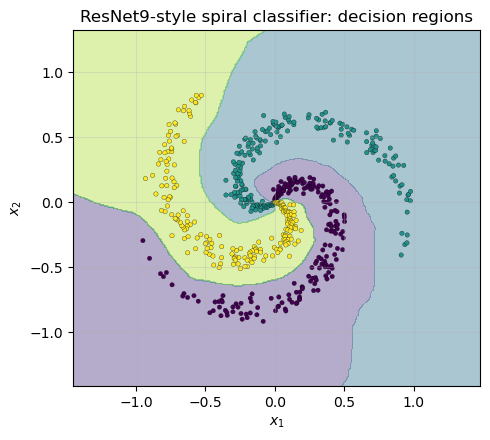

In [8]:

x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 300),
    np.linspace(x2_min, x2_max, 300),
)
grid_points = np.c_[xx1.ravel(), xx2.ravel()].astype(np.float32)
grid_t = torch.from_numpy(grid_points).to(device)

model.eval()
with torch.no_grad():
    logits_grid = model(grid_t)
    preds_grid = torch.argmax(logits_grid, dim=1).cpu().numpy()

Z = preds_grid.reshape(xx1.shape)

plt.figure(figsize=(5, 4.5))
plt.contourf(xx1, xx2, Z, levels=3, alpha=0.4, cmap="viridis")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis",
            s=10, edgecolors="k", linewidths=0.2)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("ResNet9-style spiral classifier: decision regions")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/resnet9_spiral_decision.png", dpi=300, bbox_inches="tight")
plt.show()



## 6. Gradient Norms Across Layers (Residual Case)

As a first step toward the exercise in the book, we inspect the gradient norms of
different layers for a single mini-batch. This gives a snapshot of how gradients
propagate through the residual architecture.


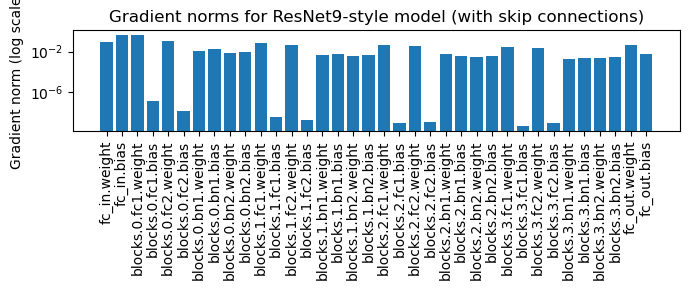

In [9]:

X_batch, y_batch = next(iter(train_loader))
X_batch = X_batch.to(device)
y_batch = y_batch.to(device)

model.train()
optimizer.zero_grad()
logits = model(X_batch)
loss = criterion(logits, y_batch)
loss.backward()

layer_names = []
grad_norms = []

for name, param in model.named_parameters():
    if param.grad is not None:
        layer_names.append(name)
        grad_norms.append(param.grad.detach().norm().item())

plt.figure(figsize=(7, 3))
plt.bar(range(len(grad_norms)), grad_norms)
plt.yscale("log")
plt.xticks(range(len(grad_norms)), layer_names, rotation=90)
plt.ylabel("Gradient norm (log scale)")
plt.title("Gradient norms for ResNet9-style model (with skip connections)")
plt.tight_layout()
plt.savefig("figs/resnet9_spiral_gradnorms.png", dpi=300, bbox_inches="tight")
plt.show()



## 7. Discussion

This toy example illustrates several key ideas from Section~\ref{sec:ResNet}:

- The residual update $h_{t+1} = h_t + f(h_t,\theta_t)$ can be interpreted as a
  discrete-time approximation of a continuous-time evolution, analogous to the Euler
  discretization of an ODE.
- Residual blocks encourage *small* incremental changes to the feature
  representation, which tends to stabilize optimization in deep networks.
- Inspecting gradient norms across layers provides one way to see how skip connections
  help maintain gradient flow through depth.

In the exercise, you will modify this notebook to remove the skip connections
(e.g., by setting `use_skip=False` in `ResidualBlock`) and compare:

- training loss and accuracy,
- decision boundaries,
- gradient norms across layers,

between the residual and non-residual architectures.
